# LANL Earthquake Prediction

### 1.1 Description

• Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

• The goal of the challenge is to capture the physical state of the laboratory fault and how close it is from failure from a snapshot of the seismic data it is emitting. You will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data.

• The input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.

• The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.

• Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time.

• Time to failure is based on a measure of fault strength (shear stress, not part of the data for the competition). When a labquake occurs this stress drops unambiguously.

• The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.


## Problem Statement:
<br>
To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

#### 1.2 Sources

https://www.kaggle.com/c/LANL-Earthquake-Prediction
<br>
https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion



<h1>2. Machine Learning problem </h1>

### 2.1 Data
train.csv - A single, continuous training segment of experimental data.




### 2.1.1 Data Overview
train.csv contains 2 columns:
<br>
• acoustic_data - the seismic signal [int16]
<br>
• time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
<br>
• Number of rows in Train.csv = 629145480

### 2.2.1 Type of Machine Leaning Problem
It is a Regression problem, for a given chunk of seismic data we need to predict the time remaining before laboratory earthquakes occur

#### 2.2.2 Performance Metric
Source: https://www.kaggle.com/c/LANL-Earthquake-Prediction#evaluation
<br>
Metric(s): Mean Absolute Error 


In [1]:

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import os

from scipy.stats import skew
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from scipy.signal import lfilter
import scipy.signal 

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD


from catboost import CatBoostRegressor,Pool


import os
import time
import warnings
import traceback
import numpy as np
import pandas as pd
from scipy import stats
import scipy.signal as sg
import multiprocessing as mp
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tsfresh.feature_extraction import feature_calculators

import scipy as sp
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

I have used several kernels from kaggle and ideas from discussion threads .
<br>
https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392
<br>
https://www.kaggle.com/allunia/shaking-earth
<br>
https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [8]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [99]:
train.shape

(629145480, 2)

There are 6.2 billion datapoints

In [98]:
# to show all the decimal points
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


We can see that for each sample the time to failure decreases by 1.1e-9

In [42]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


75% of the acoustic data is below 7 and the max value is 5.4e+03, i e only few values are approximately 5.4e+03

### Visualizing Train data

### Number of occurences of Earthquake

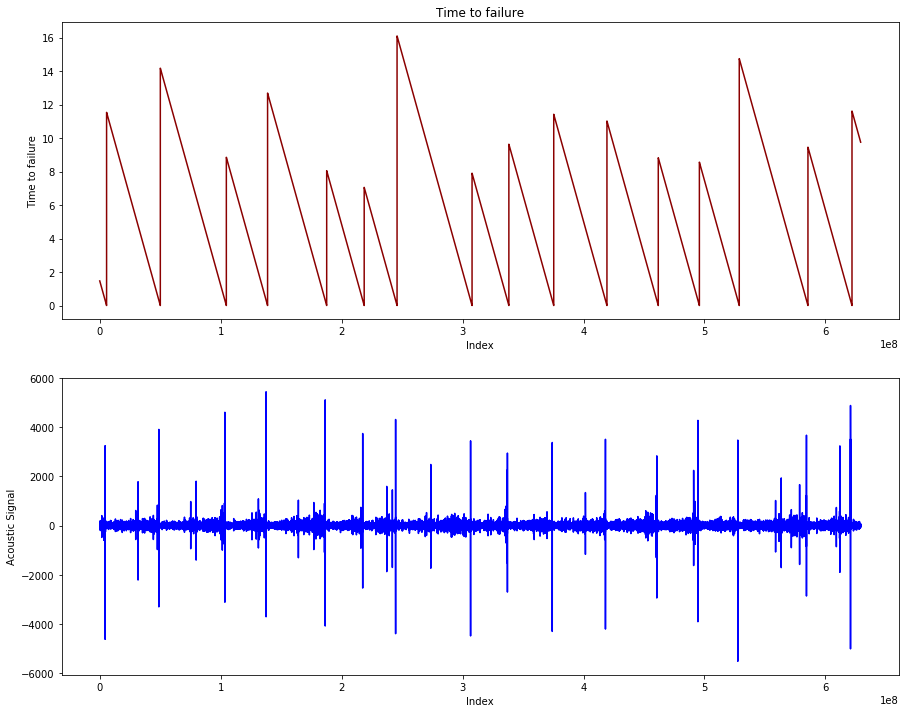

In [5]:
#plotting the train data
fig, ax = plt.subplots(2,1, figsize=(15,12))
ax[0].plot(train.index.values, train.time_to_failure.values, c="darkred")
ax[0].set_title("Time to failure")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to failure");
ax[1].plot(train.index.values, train.acoustic_data.values, c="blue")
#ax[1].set_title("Index")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal")
plt.show()

It is given that the earthquake occurs when the time_to_failure hits 0, hence we can count that there are 16 occurences of earthquake in the whole training data

### Relationship between time to failure and acoustic data

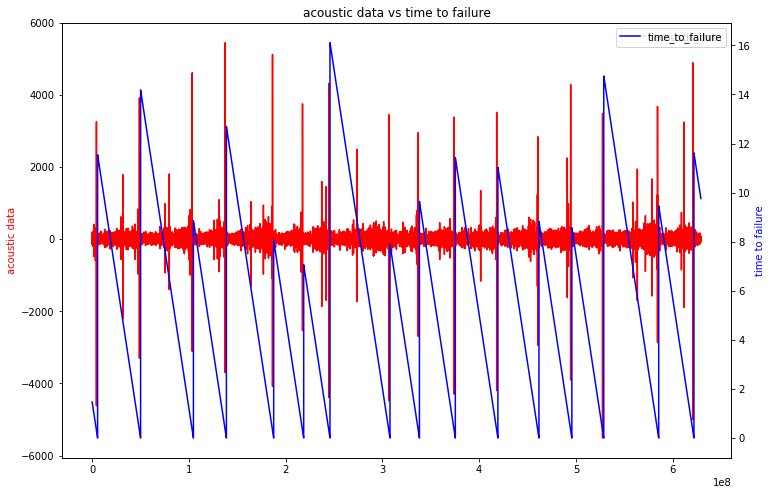

In [4]:
#plotting acoustic data vs time to failure
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data,color='r')
plt.legend()
ax1.set_ylabel('acoustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure,color='b')
plt.title('acoustic data vs time to failure')
plt.legend()
plt.show()

The acoustic data has a peak just before time to failure hits zero. We can verify it by zooming into the plot.

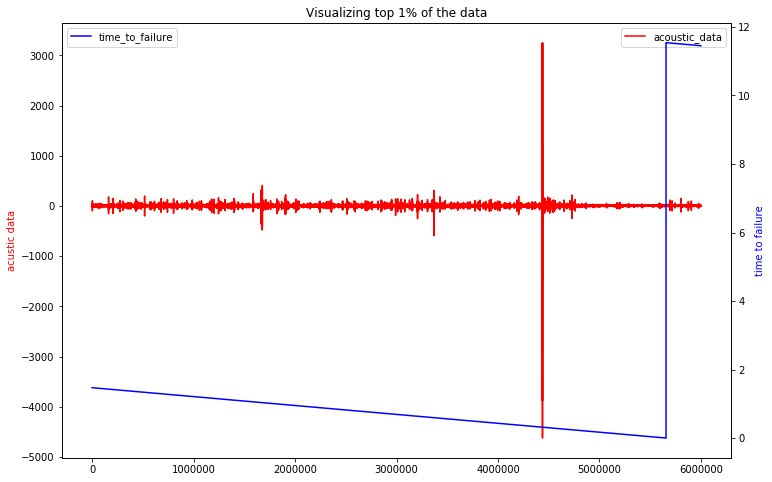

In [5]:
#plotting only top 1% of the value
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data[0:6000000],color='r')
plt.legend()
ax1.set_ylabel('acustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure[0:6000000],color='b')
plt.title('Visualizing top 1% of the data')
plt.legend()
plt.show()

If we zoom into the data we can see that the acoustic data has a peak just before the earthquake occurs and the whole training data follows the same pattern

### Is time to failure continously Decreasing

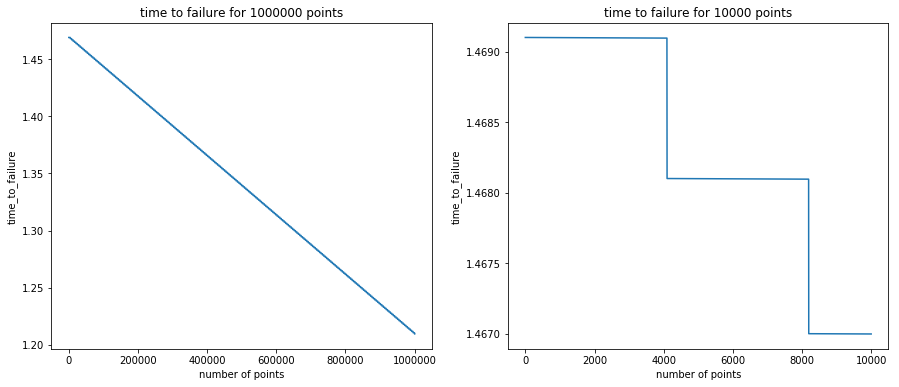

In [3]:
#plotting time to failure for fewer data
fig = plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.plot(train.time_to_failure[0:1000000])
plt.title('time to failure for 1000000 points')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
 
plt.subplot(1,2,2)
plt.plot(train.time_to_failure[0:10000])
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.title('time to failure for 10000 points')

plt.show()

If we plot the data for 1000000 points we can see that the graph is continously decreasing but if we zoom into it we can see that the time_to_failure stops decreasing for a while when it reaches ~4000 samples.
<br>
It is due to the fact that the data is recorded in bins of 4096 samples and the recording device stops for 12 microseconds after each bin.

### Visualizing Test Data

In [36]:
#Reading the test data
from tqdm.auto import tqdm
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test = pd.DataFrame(dtype=np.float64, index=submission.index)
whole_test=[]
for seg_id in tqdm(test.index):
    seg = pd.read_csv('Untitled Folder/' + seg_id + '.csv')
    for i in seg['acoustic_data'].values:
        whole_test.append(i)

In [40]:
#total number of datapoints in test
len(whole_test)

393600000

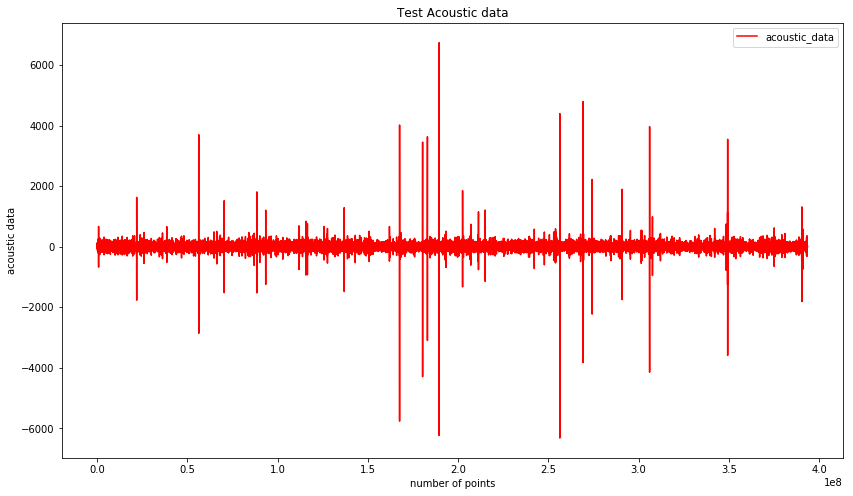

In [39]:
#plotting test data
fig = plt.figure(figsize=(14, 8))

plt.plot(whole_test,color='r',label='acoustic_data')
plt.title('Test Acoustic data')
plt.xlabel('number of points')
plt.ylabel('acoustic data')
plt.legend()
plt.show()
 

#### Checking for Null values

In [41]:
train.isnull().any().any()

False

There are no null values in the whole training data

# Featurization

### Feature set 1

In [2]:
OUTPUT_DIR = ''  # set for local environment
DATA_DIR = ''  # set for local environment

SIG_LEN = 150000
NUM_SEG_PER_PROC = 4000
NUM_THREADS = 6

NY_FREQ_IDX = 75000  # the test signals are 150k samples long, Nyquist is thus 75k.
CUTOFF = 18000
MAX_FREQ_IDX = 20000
FREQ_STEP = 2500

In [ ]:

# into 6 slices
def split_raw_data():
    df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

    max_start_index = len(df.index) - SIG_LEN
    slice_len = int(max_start_index / 6)

    for i in tqdm(range(NUM_THREADS)):
        print('working', i)
        df0 = df.iloc[slice_len * i: (slice_len * (i + 1)) + SIG_LEN]
        df0.to_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % i), index=False)
        del df0

    del df

In [ ]:
#building random indices 
def build_rnd_idxs():
    rnd_idxs = np.zeros(shape=(NUM_THREADS, NUM_SEG_PER_PROC), dtype=np.int32)
    max_start_idx = 100000000

    for i in range(NUM_THREADS):
        np.random.seed(5591 + i)
        start_indices = np.random.randint(0, max_start_idx, size=NUM_SEG_PER_PROC, dtype=np.int32)
        rnd_idxs[i, :] = start_indices

    for i in range(NUM_THREADS):
        print(rnd_idxs[i, :8])
        print(rnd_idxs[i, -8:])
        print(min(rnd_idxs[i,:]), max(rnd_idxs[i,:]))

    np.savetxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), X=np.transpose(rnd_idxs), fmt='%d', delimiter=',')

In [5]:
#finding the slope 
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [6]:
def des_bw_filter_lp(cutoff=CUTOFF):  # low pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX)
    return b, a

def des_bw_filter_hp(cutoff=CUTOFF):  # high pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX, btype='highpass')
    return b, a

def des_bw_filter_bp(low, high):  # band pass filter
    b, a = sg.butter(4, Wn=(low/NY_FREQ_IDX, high/NY_FREQ_IDX), btype='bandpass')
    return b, a

In [4]:
# a function to create features
def create_features(seg_id, seg, X, st, end):
    try:
        X.loc[seg_id, 'seg_id'] = np.int32(seg_id)
        X.loc[seg_id, 'seg_start'] = np.int32(st)
        X.loc[seg_id, 'seg_end'] = np.int32(end)
    except:
        pass

    xc = pd.Series(seg['acoustic_data'].values)
    xcdm = xc - np.mean(xc)

    b, a = des_bw_filter_lp(cutoff=18000)
    xcz = sg.lfilter(b, a, xcdm)

    zc = np.fft.fft(xcz)
    zc = zc[:MAX_FREQ_IDX]

    # FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    freq_bands = [x for x in range(0, MAX_FREQ_IDX, FREQ_STEP)]
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    for freq in freq_bands:
        X.loc[seg_id, 'FFT_Mag_01q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        X.loc[seg_id, 'FFT_Mag_10q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        X.loc[seg_id, 'FFT_Mag_90q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        X.loc[seg_id, 'FFT_Mag_99q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        X.loc[seg_id, 'FFT_Mag_mean%d' % freq] = np.mean(magFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Mag_std%d' % freq] = np.std(magFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Mag_max%d' % freq] = np.max(magFFT[freq: freq + FREQ_STEP])

        X.loc[seg_id, 'FFT_Phz_mean%d' % freq] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Phz_std%d' % freq] = np.std(phzFFT[freq: freq + FREQ_STEP])

    X.loc[seg_id, 'FFT_Rmean'] = realFFT.mean()
    X.loc[seg_id, 'FFT_Rstd'] = realFFT.std()
    X.loc[seg_id, 'FFT_Rmax'] = realFFT.max()
    X.loc[seg_id, 'FFT_Rmin'] = realFFT.min()
    X.loc[seg_id, 'FFT_Imean'] = imagFFT.mean()
    X.loc[seg_id, 'FFT_Istd'] = imagFFT.std()
    X.loc[seg_id, 'FFT_Imax'] = imagFFT.max()
    X.loc[seg_id, 'FFT_Imin'] = imagFFT.min()

    X.loc[seg_id, 'FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    X.loc[seg_id, 'FFT_Rstd__first_6000'] = realFFT[:6000].std()
    X.loc[seg_id, 'FFT_Rmax_first_6000'] = realFFT[:6000].max()
    X.loc[seg_id, 'FFT_Rmin_first_6000'] = realFFT[:6000].min()
    X.loc[seg_id, 'FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    X.loc[seg_id, 'FFT_Rstd_first_18000'] = realFFT[:18000].std()
    X.loc[seg_id, 'FFT_Rmax_first_18000'] = realFFT[:18000].max()
    X.loc[seg_id, 'FFT_Rmin_first_18000'] = realFFT[:18000].min()

    del xcz
    del zc

    b, a = des_bw_filter_lp(cutoff=2500)
    xc0 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=2500, high=5000)
    xc1 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=5000, high=7500)
    xc2 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=7500, high=10000)
    xc3 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=10000, high=12500)
    xc4 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=12500, high=15000)
    xc5 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=15000, high=17500)
    xc6 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=17500, high=20000)
    xc7 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_hp(cutoff=20000)
    xc8 = sg.lfilter(b, a, xcdm)

    sigs = [xc, pd.Series(xc0), pd.Series(xc1), pd.Series(xc2), pd.Series(xc3),
            pd.Series(xc4), pd.Series(xc5), pd.Series(xc6), pd.Series(xc7), pd.Series(xc8)]

    for i, sig in enumerate(sigs):
        X.loc[seg_id, 'mean_%d' % i] = sig.mean()
        X.loc[seg_id, 'std_%d' % i] = sig.std()
        X.loc[seg_id, 'max_%d' % i] = sig.max()
        X.loc[seg_id, 'min_%d' % i] = sig.min()

        X.loc[seg_id, 'mean_change_abs_%d' % i] = np.mean(np.diff(sig))
        X.loc[seg_id, 'mean_change_rate_%d' % i] = np.mean(np.nonzero((np.diff(sig) / sig[:-1]))[0])
        X.loc[seg_id, 'abs_max_%d' % i] = np.abs(sig).max()
        X.loc[seg_id, 'abs_min_%d' % i] = np.abs(sig).min()

        X.loc[seg_id, 'std_first_50000_%d' % i] = sig[:50000].std()
        X.loc[seg_id, 'std_last_50000_%d' % i] = sig[-50000:].std()
        X.loc[seg_id, 'std_first_10000_%d' % i] = sig[:10000].std()
        X.loc[seg_id, 'std_last_10000_%d' % i] = sig[-10000:].std()

        X.loc[seg_id, 'avg_first_50000_%d' % i] = sig[:50000].mean()
        X.loc[seg_id, 'avg_last_50000_%d' % i] = sig[-50000:].mean()
        X.loc[seg_id, 'avg_first_10000_%d' % i] = sig[:10000].mean()
        X.loc[seg_id, 'avg_last_10000_%d' % i] = sig[-10000:].mean()

        X.loc[seg_id, 'min_first_50000_%d' % i] = sig[:50000].min()
        X.loc[seg_id, 'min_last_50000_%d' % i] = sig[-50000:].min()
        X.loc[seg_id, 'min_first_10000_%d' % i] = sig[:10000].min()
        X.loc[seg_id, 'min_last_10000_%d' % i] = sig[-10000:].min()

        X.loc[seg_id, 'max_first_50000_%d' % i] = sig[:50000].max()
        X.loc[seg_id, 'max_last_50000_%d' % i] = sig[-50000:].max()
        X.loc[seg_id, 'max_first_10000_%d' % i] = sig[:10000].max()
        X.loc[seg_id, 'max_last_10000_%d' % i] = sig[-10000:].max()

        X.loc[seg_id, 'max_to_min_%d' % i] = sig.max() / np.abs(sig.min())
        X.loc[seg_id, 'max_to_min_diff_%d' % i] = sig.max() - np.abs(sig.min())
        X.loc[seg_id, 'count_big_%d' % i] = len(sig[np.abs(sig) > 500])
        X.loc[seg_id, 'sum_%d' % i] = sig.sum()

        X.loc[seg_id, 'mean_change_rate_first_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:50000]) / sig[:50000][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_last_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-50000:]) / sig[-50000:][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_first_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:10000]) / sig[:10000][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_last_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-10000:]) / sig[-10000:][:-1]))[0])

        X.loc[seg_id, 'q95_%d' % i] = np.quantile(sig, 0.95)
        X.loc[seg_id, 'q99_%d' % i] = np.quantile(sig, 0.99)
        X.loc[seg_id, 'q05_%d' % i] = np.quantile(sig, 0.05)
        X.loc[seg_id, 'q01_%d' % i] = np.quantile(sig, 0.01)

        X.loc[seg_id, 'abs_q95_%d' % i] = np.quantile(np.abs(sig), 0.95)
        X.loc[seg_id, 'abs_q99_%d' % i] = np.quantile(np.abs(sig), 0.99)
        X.loc[seg_id, 'abs_q05_%d' % i] = np.quantile(np.abs(sig), 0.05)
        X.loc[seg_id, 'abs_q01_%d' % i] = np.quantile(np.abs(sig), 0.01)

        X.loc[seg_id, 'trend_%d' % i] = add_trend_feature(sig)
        X.loc[seg_id, 'abs_trend_%d' % i] = add_trend_feature(sig, abs_values=True)
        X.loc[seg_id, 'abs_mean_%d' % i] = np.abs(sig).mean()
        X.loc[seg_id, 'abs_std_%d' % i] = np.abs(sig).std()

        X.loc[seg_id, 'mad_%d' % i] = sig.mad()
        X.loc[seg_id, 'kurt_%d' % i] = sig.kurtosis()
        X.loc[seg_id, 'skew_%d' % i] = sig.skew()
        X.loc[seg_id, 'med_%d' % i] = sig.median()

        X.loc[seg_id, 'Hilbert_mean_%d' % i] = np.abs(hilbert(sig)).mean()
        X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()

        X.loc[seg_id, 'classic_sta_lta1_mean_%d' % i] = classic_sta_lta(sig, 500, 10000).mean()
        X.loc[seg_id, 'classic_sta_lta2_mean_%d' % i] = classic_sta_lta(sig, 5000, 100000).mean()
        X.loc[seg_id, 'classic_sta_lta3_mean_%d' % i] = classic_sta_lta(sig, 3333, 6666).mean()
        X.loc[seg_id, 'classic_sta_lta4_mean_%d' % i] = classic_sta_lta(sig, 10000, 25000).mean()

        X.loc[seg_id, 'Moving_average_700_mean_%d' % i] = sig.rolling(window=700).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_1500_mean_%d' % i] = sig.rolling(window=1500).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_3000_mean_%d' % i] = sig.rolling(window=3000).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_6000_mean_%d' % i] = sig.rolling(window=6000).mean().mean(skipna=True)

        ewma = pd.Series.ewm
        X.loc[seg_id, 'exp_Moving_average_300_mean_%d' % i] = ewma(sig, span=300).mean().mean(skipna=True)
        X.loc[seg_id, 'exp_Moving_average_3000_mean_%d' % i] = ewma(sig, span=3000).mean().mean(skipna=True)
        X.loc[seg_id, 'exp_Moving_average_30000_mean_%d' % i] = ewma(sig, span=6000).mean().mean(skipna=True)

        no_of_std = 2
        X.loc[seg_id, 'MA_700MA_std_mean_%d' % i] = sig.rolling(window=700).std().mean()
        X.loc[seg_id, 'MA_700MA_BB_high_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_700MA_BB_low_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_400MA_std_mean_%d' % i] = sig.rolling(window=400).std().mean()
        X.loc[seg_id, 'MA_400MA_BB_high_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_400MA_BB_low_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_1000MA_std_mean_%d' % i] = sig.rolling(window=1000).std().mean()

        X.loc[seg_id, 'iqr_%d' % i] = np.subtract(*np.percentile(sig, [75, 25]))
        X.loc[seg_id, 'q999_%d' % i] = np.quantile(sig, 0.999)
        X.loc[seg_id, 'q001_%d' % i] = np.quantile(sig, 0.001)
        X.loc[seg_id, 'ave10_%d' % i] = stats.trim_mean(sig, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values

        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

    return X

In [8]:

def build_fields(proc_id):
    success = 1
    count = 0
    try:
        seg_st = int(NUM_SEG_PER_PROC * proc_id)
        train_df = pd.read_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % proc_id), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
        len_df = len(train_df.index)
        start_indices = (np.loadtxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), dtype=np.int32, delimiter=','))[:, proc_id]
        train_X = pd.DataFrame(dtype=np.float64)
        train_y = pd.DataFrame(dtype=np.float64, columns=['time_to_failure'])
        t0 = time.time()

        for seg_id, start_idx in zip(range(seg_st, seg_st + NUM_SEG_PER_PROC), start_indices):
            end_idx = np.int32(start_idx + 150000)
            print('working: %d, %d, %d to %d of %d' % (proc_id, seg_id, start_idx, end_idx, len_df))
            seg = train_df.iloc[start_idx: end_idx]
            # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
            train_X = create_features(seg_id, seg, train_X, start_idx, end_idx)
            train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

            if count == 10: 
                print('saving: %d, %d to %d' % (seg_id, start_idx, end_idx))
                train_X.to_csv('train_x_%d.csv' % proc_id, index=False)
                
                train_y.to_csv('train_y_%d.csv' % proc_id, index=False)

            count += 1

        print('final_save, process id: %d, loop time: %.2f for %d iterations' % (proc_id, time.time() - t0, count))
        train_X.to_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % proc_id), index=False)
        train_y.to_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % proc_id), index=False)

    except:
        print(traceback.format_exc())
        success = 0

    return success  # 1 on success, 0 if fail

In [9]:
#for multiprocessing
def run_mp_build():
    t0 = time.time()
    num_proc = NUM_THREADS
    pool = mp.Pool(processes=num_proc)
    results = [pool.apply_async(build_fields, args=(pid, )) for pid in range(NUM_THREADS)]
    output = [p.get() for p in results]
    num_built = sum(output)
    pool.close()
    pool.join()
    print(num_built)
    print('Run time: %.2f' % (time.time() - t0))

In [10]:
def join_mp_build():
    df0 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % 0))
    df1 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % 0))

    for i in range(1, NUM_THREADS):
        print('working %d' % i)
        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % i))
        df0 = df0.append(temp)

        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % i))
        df1 = df1.append(temp)

    df0.to_csv(os.path.join(OUTPUT_DIR, 'train_x.csv'), index=False)
    df1.to_csv(os.path.join(OUTPUT_DIR, 'train_y.csv'), index=False)

In [11]:

from tqdm.auto import tqdm
def build_test_fields():
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x.csv'))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass

    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

    print('start for loop')
    count = 0
    for seg_id in tqdm(test_X.index):  # just tqdm in IDE
        seg = pd.read_csv(os.path.join(DATA_DIR, 'Untitled Folder/', str(seg_id) + '.csv'))
        # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
        test_X = create_features(seg_id, seg, test_X, 0, 0)

        if count % 100 == 0:
            print('working', seg_id)
        count += 1

    test_X.to_csv(os.path.join(OUTPUT_DIR, 'test_x.csv'), index=False)

In [12]:
#standardization
def scale_fields(fn_train='train_x.csv', fn_test='test_x.csv', 
                 fn_out_train='scaled_train_X.csv' , fn_out_test='scaled_test_X.csv'):
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_train))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass
    test_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_test))

    print('start scaler')
    scaler = StandardScaler()
    scaler.fit(train_X)
    scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
    scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

    scaled_train_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_train), index=False)
    scaled_test_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_test), index=False)

In [ ]:
split_raw_data()

In [20]:
build_rnd_idxs()

[10804991 40754581 61152051 51046969 26130885 37920772 36775305  7675825]
[68761251 51632120 86559696 90282599 60663556 85061082 95027462 23825753]
67619 99994297
[16837712 49519822 86613139  3210689 98148542 31101347  1090339 72122324]
[79426720 43809532 43249236 23265647 44502411 86787131 90136975 34661131]
26666 99956067
[63044133  2442657 90777691 16268569 63311688 90814034 75756302 37813113]
[91763196  7353084 29675563 12721978 64093656 39100415  2453472 56466376]
19628 99986179
[61673177 33536021 43935586 94121751  3158245 18377637 64912898 52164547]
[98328338 73239137 19836471 25502780 59800782 58627599 55588218 24985417]
2272 99981324
[59879818 56182569 67051701 16143352 53734196 57460600 55941981 67579513]
[11170509 67106840 93093344  4809245 73117841 87221360   829083 51383467]
26823 99942141
[26548514  5175447 39498226 33934210 76764021 34939489 82316461 79515410]
[67651567 76925054 97654318 99863711 49392180 70557795 10896601 75562170]
71058 99981201


In [ ]:
run_mp_build()

In [30]:
join_mp_build()

working 1
working 2
working 3
working 4
working 5


In [ ]:
build_test_fields()

In [14]:
scale_fields()

start scaler


### Featurizing original data

In [8]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
X_check = pd.DataFrame(index=range(segments), dtype=np.float64)
y_check = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [9]:
#building features for original 4194 features to plot and check the predictions
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
for seg_id in tqdm(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    xc = pd.Series(seg['acoustic_data'].values)
    xcdm = xc - np.mean(xc)
    y = seg['time_to_failure'].values[-1]
    y_check.loc[seg_id, 'time_to_failure'] = y
    
    b, a = des_bw_filter_lp(cutoff=18000)
    xcz = sg.lfilter(b, a, xcdm)

    zc = np.fft.fft(xcz)
    zc = zc[:MAX_FREQ_IDX]

    # FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    freq_bands = [x for x in range(0, MAX_FREQ_IDX, FREQ_STEP)]
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    for freq in freq_bands:
        X_check.loc[seg_id, 'FFT_Mag_01q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        X_check.loc[seg_id, 'FFT_Mag_10q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        X_check.loc[seg_id, 'FFT_Mag_90q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        X_check.loc[seg_id, 'FFT_Mag_99q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        X_check.loc[seg_id, 'FFT_Mag_mean%d' % freq] = np.mean(magFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Mag_std%d' % freq] = np.std(magFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Mag_max%d' % freq] = np.max(magFFT[freq: freq + FREQ_STEP])

        X_check.loc[seg_id, 'FFT_Phz_mean%d' % freq] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Phz_std%d' % freq] = np.std(phzFFT[freq: freq + FREQ_STEP])

    X_check.loc[seg_id, 'FFT_Rmean'] = realFFT.mean()
    X_check.loc[seg_id, 'FFT_Rstd'] = realFFT.std()
    X_check.loc[seg_id, 'FFT_Rmax'] = realFFT.max()
    X_check.loc[seg_id, 'FFT_Rmin'] = realFFT.min()
    X_check.loc[seg_id, 'FFT_Imean'] = imagFFT.mean()
    X_check.loc[seg_id, 'FFT_Istd'] = imagFFT.std()
    X_check.loc[seg_id, 'FFT_Imax'] = imagFFT.max()
    X_check.loc[seg_id, 'FFT_Imin'] = imagFFT.min()

    X_check.loc[seg_id, 'FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    X_check.loc[seg_id, 'FFT_Rstd__first_6000'] = realFFT[:6000].std()
    X_check.loc[seg_id, 'FFT_Rmax_first_6000'] = realFFT[:6000].max()
    X_check.loc[seg_id, 'FFT_Rmin_first_6000'] = realFFT[:6000].min()
    X_check.loc[seg_id, 'FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    X_check.loc[seg_id, 'FFT_Rstd_first_18000'] = realFFT[:18000].std()
    X_check.loc[seg_id, 'FFT_Rmax_first_18000'] = realFFT[:18000].max()
    X_check.loc[seg_id, 'FFT_Rmin_first_18000'] = realFFT[:18000].min()

    del xcz
    del zc

    b, a = des_bw_filter_lp(cutoff=2500)
    xc0 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=2500, high=5000)
    xc1 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=5000, high=7500)
    xc2 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=7500, high=10000)
    xc3 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=10000, high=12500)
    xc4 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=12500, high=15000)
    xc5 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=15000, high=17500)
    xc6 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=17500, high=20000)
    xc7 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_hp(cutoff=20000)
    xc8 = sg.lfilter(b, a, xcdm)

    sigs = [xc, pd.Series(xc0), pd.Series(xc1), pd.Series(xc2), pd.Series(xc3),
            pd.Series(xc4), pd.Series(xc5), pd.Series(xc6), pd.Series(xc7), pd.Series(xc8)]

    for i, sig in enumerate(sigs):
        X_check.loc[seg_id, 'mean_%d' % i] = sig.mean()
        X_check.loc[seg_id, 'std_%d' % i] = sig.std()
        X_check.loc[seg_id, 'max_%d' % i] = sig.max()
        X_check.loc[seg_id, 'min_%d' % i] = sig.min()

        X_check.loc[seg_id, 'mean_change_abs_%d' % i] = np.mean(np.diff(sig))
        X_check.loc[seg_id, 'mean_change_rate_%d' % i] = np.mean(np.nonzero((np.diff(sig) / sig[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_%d' % i] = np.abs(sig).max()
        X_check.loc[seg_id, 'abs_min_%d' % i] = np.abs(sig).min()

        X_check.loc[seg_id, 'std_first_50000_%d' % i] = sig[:50000].std()
        X_check.loc[seg_id, 'std_last_50000_%d' % i] = sig[-50000:].std()
        X_check.loc[seg_id, 'std_first_10000_%d' % i] = sig[:10000].std()
        X_check.loc[seg_id, 'std_last_10000_%d' % i] = sig[-10000:].std()

        X_check.loc[seg_id, 'avg_first_50000_%d' % i] = sig[:50000].mean()
        X_check.loc[seg_id, 'avg_last_50000_%d' % i] = sig[-50000:].mean()
        X_check.loc[seg_id, 'avg_first_10000_%d' % i] = sig[:10000].mean()
        X_check.loc[seg_id, 'avg_last_10000_%d' % i] = sig[-10000:].mean()

        X_check.loc[seg_id, 'min_first_50000_%d' % i] = sig[:50000].min()
        X_check.loc[seg_id, 'min_last_50000_%d' % i] = sig[-50000:].min()
        X_check.loc[seg_id, 'min_first_10000_%d' % i] = sig[:10000].min()
        X_check.loc[seg_id, 'min_last_10000_%d' % i] = sig[-10000:].min()

        X_check.loc[seg_id, 'max_first_50000_%d' % i] = sig[:50000].max()
        X_check.loc[seg_id, 'max_last_50000_%d' % i] = sig[-50000:].max()
        X_check.loc[seg_id, 'max_first_10000_%d' % i] = sig[:10000].max()
        X_check.loc[seg_id, 'max_last_10000_%d' % i] = sig[-10000:].max()

        X_check.loc[seg_id, 'max_to_min_%d' % i] = sig.max() / np.abs(sig.min())
        X_check.loc[seg_id, 'max_to_min_diff_%d' % i] = sig.max() - np.abs(sig.min())
        X_check.loc[seg_id, 'count_big_%d' % i] = len(sig[np.abs(sig) > 500])
        X_check.loc[seg_id, 'sum_%d' % i] = sig.sum()

        X_check.loc[seg_id, 'mean_change_rate_first_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:50000]) / sig[:50000][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_last_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-50000:]) / sig[-50000:][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_first_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:10000]) / sig[:10000][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_last_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-10000:]) / sig[-10000:][:-1]))[0])

        X_check.loc[seg_id, 'q95_%d' % i] = np.quantile(sig, 0.95)
        X_check.loc[seg_id, 'q99_%d' % i] = np.quantile(sig, 0.99)
        X_check.loc[seg_id, 'q05_%d' % i] = np.quantile(sig, 0.05)
        X_check.loc[seg_id, 'q01_%d' % i] = np.quantile(sig, 0.01)

        X_check.loc[seg_id, 'abs_q95_%d' % i] = np.quantile(np.abs(sig), 0.95)
        X_check.loc[seg_id, 'abs_q99_%d' % i] = np.quantile(np.abs(sig), 0.99)
        X_check.loc[seg_id, 'abs_q05_%d' % i] = np.quantile(np.abs(sig), 0.05)
        X_check.loc[seg_id, 'abs_q01_%d' % i] = np.quantile(np.abs(sig), 0.01)

        X_check.loc[seg_id, 'trend_%d' % i] = add_trend_feature(sig)
        X_check.loc[seg_id, 'abs_trend_%d' % i] = add_trend_feature(sig, abs_values=True)
        X_check.loc[seg_id, 'abs_mean_%d' % i] = np.abs(sig).mean()
        X_check.loc[seg_id, 'abs_std_%d' % i] = np.abs(sig).std()

        X_check.loc[seg_id, 'mad_%d' % i] = sig.mad()
        X_check.loc[seg_id, 'kurt_%d' % i] = sig.kurtosis()
        X_check.loc[seg_id, 'skew_%d' % i] = sig.skew()
        X_check.loc[seg_id, 'med_%d' % i] = sig.median()

        X_check.loc[seg_id, 'Hilbert_mean_%d' % i] = np.abs(hilbert(sig)).mean()
        X_check.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()

        X_check.loc[seg_id, 'classic_sta_lta1_mean_%d' % i] = classic_sta_lta(sig, 500, 10000).mean()
        X_check.loc[seg_id, 'classic_sta_lta2_mean_%d' % i] = classic_sta_lta(sig, 5000, 100000).mean()
        X_check.loc[seg_id, 'classic_sta_lta3_mean_%d' % i] = classic_sta_lta(sig, 3333, 6666).mean()
        X_check.loc[seg_id, 'classic_sta_lta4_mean_%d' % i] = classic_sta_lta(sig, 10000, 25000).mean()

        X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] = sig.rolling(window=700).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_1500_mean_%d' % i] = sig.rolling(window=1500).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_3000_mean_%d' % i] = sig.rolling(window=3000).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_6000_mean_%d' % i] = sig.rolling(window=6000).mean().mean(skipna=True)

        ewma = pd.Series.ewm
        X_check.loc[seg_id, 'exp_Moving_average_300_mean_%d' % i] = ewma(sig, span=300).mean().mean(skipna=True)
        X_check.loc[seg_id, 'exp_Moving_average_3000_mean_%d' % i] = ewma(sig, span=3000).mean().mean(skipna=True)
        X_check.loc[seg_id, 'exp_Moving_average_30000_mean_%d' % i] = ewma(sig, span=6000).mean().mean(skipna=True)

        no_of_std = 2
        X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i] = sig.rolling(window=700).std().mean()
        X_check.loc[seg_id, 'MA_700MA_BB_high_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_700MA_BB_low_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i] = sig.rolling(window=400).std().mean()
        X_check.loc[seg_id, 'MA_400MA_BB_high_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_400MA_BB_low_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_1000MA_std_mean_%d' % i] = sig.rolling(window=1000).std().mean()

        X_check.loc[seg_id, 'iqr_%d' % i] = np.subtract(*np.percentile(sig, [75, 25]))
        X_check.loc[seg_id, 'q999_%d' % i] = np.quantile(sig, 0.999)
        X_check.loc[seg_id, 'q001_%d' % i] = np.quantile(sig, 0.001)
        X_check.loc[seg_id, 'ave10_%d' % i] = stats.trim_mean(sig, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values

        X_check.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_check.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_check.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_check.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_check.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_check.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_check.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_check.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_check.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_check.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X_check.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_check.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_check.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_check.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_check.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_check.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_check.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_check.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_check.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_check.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [11]:
scaler = StandardScaler()
scaler.fit(X_check)
scaled_check_X = pd.DataFrame(scaler.transform(X_check), columns=X_check.columns)

In [13]:

scaled_check_X.to_csv(os.path.join(OUTPUT_DIR, 'scaled_check_X.csv'), index=False)

In [14]:
scaled_check_X=pd.read_csv('scaled_check_X.csv')
scaled_check_X.head()

,FFT_Mag_01q0,FFT_Mag_10q0,FFT_Mag_90q0,FFT_Mag_99q0,FFT_Mag_mean0,FFT_Mag_std0,FFT_Mag_max0,FFT_Phz_mean0,FFT_Phz_std0,FFT_Mag_01q2500,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,-0.060473,-0.085420,-0.137072,-0.152365,-0.121781,-0.126132,0.218116,0.950155,-1.864500,-0.140295,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,-0.102473,-0.036434,0.028897,0.014212,0.004478,0.014293,-0.302923,-0.030805,0.967366,0.023442,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,-0.049900,-0.039858,-0.003688,-0.003713,-0.014248,-0.003003,0.015514,-1.484378,-0.137772,0.131602,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,0.013489,-0.024736,0.154143,0.301586,0.108312,0.238146,0.053061,0.986414,-0.535139,0.037916,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,-0.066028,-0.029450,-0.015406,0.031369,-0.017600,-0.006492,-0.272360,-0.609263,-0.875324,0.050317,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032


# Feature set 2

In [5]:
#http://gilestrolab.github.io/pyrem/pyrem.univariate.html
#http://pyeeg.sourceforge.net/
#returns acivity, mobility and complexity of the signal
def hjorth(a):
    
    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

In [6]:
import scipy
def create_features_set2(seg_id, seg, X, st, end):
    try:
        X.loc[seg_id, 'seg_id'] = np.int32(seg_id)
        X.loc[seg_id, 'seg_start'] = np.int32(st)
        X.loc[seg_id, 'seg_end'] = np.int32(end)
    except:
        pass

    x = seg['acoustic_data'].values
    
    X.loc[seg_id,'kstat_1'] = sp.stats.kstat(x, 1)
    X.loc[seg_id,'kstat_2'] = sp.stats.kstat(x, 2)
    X.loc[seg_id,'kstat_3'] = sp.stats.kstat(x, 3)
    X.loc[seg_id,'kstat_4'] = sp.stats.kstat(x, 4)
    X.loc[seg_id,'moment_1'] = sp.stats.moment(x, 1)
    X.loc[seg_id,'moment_2'] = sp.stats.moment(x, 2)
    X.loc[seg_id,'moment_3'] = sp.stats.moment(x, 3)
    X.loc[seg_id,'moment_4'] = sp.stats.moment(x, 4)
        
    X.loc[seg_id,'abs_energy'] = feature_calculators.abs_energy(x)
    X.loc[seg_id,'abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
    X.loc[seg_id,'count_above_mean'] = feature_calculators.count_above_mean(x)
    X.loc[seg_id,'count_below_mean'] = feature_calculators.count_below_mean(x)
    X.loc[seg_id,'mean_abs_change'] = feature_calculators.mean_abs_change(x)
    X.loc[seg_id,'mean_change'] = feature_calculators.mean_change(x)
    X.loc[seg_id,'var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
    X.loc[seg_id,'range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)

    X.loc[seg_id,'range_m4000_m3000'] = feature_calculators.range_count(x, -4000, -3000)
    X.loc[seg_id,'range_m3000_m2000'] = feature_calculators.range_count(x, -3000, -2000)
    X.loc[seg_id,'range_m2000_m1000'] = feature_calculators.range_count(x, -2000, -1000)
    X.loc[seg_id,'range_m1000_0'] = feature_calculators.range_count(x, -1000, 0)
    X.loc[seg_id,'range_0_p1000'] = feature_calculators.range_count(x, 0, 1000)
    X.loc[seg_id,'range_p1000_p2000'] = feature_calculators.range_count(x, 1000, 2000)
    X.loc[seg_id,'range_p2000_p3000'] = feature_calculators.range_count(x, 2000, 3000)
    X.loc[seg_id,'range_p3000_p4000'] = feature_calculators.range_count(x, 3000, 4000)
    X.loc[seg_id,'range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

    X.loc[seg_id,'ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
    X.loc[seg_id,'first_loc_min'] = feature_calculators.first_location_of_minimum(x)
    X.loc[seg_id,'first_loc_max'] = feature_calculators.first_location_of_maximum(x)
    X.loc[seg_id,'last_loc_min'] = feature_calculators.last_location_of_minimum(x)
    X.loc[seg_id,'last_loc_max'] = feature_calculators.last_location_of_maximum(x)
    X.loc[seg_id,'time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    X.loc[seg_id,'time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
    X.loc[seg_id,'time_rev_asym_stat_1000'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1000)
    X.loc[seg_id,'autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
    X.loc[seg_id,'autocorrelation_10'] = feature_calculators.autocorrelation(x, 10)
    X.loc[seg_id,'autocorrelation_50'] = feature_calculators.autocorrelation(x, 50)
    X.loc[seg_id,'autocorrelation_100'] = feature_calculators.autocorrelation(x, 100)
    X.loc[seg_id,'autocorrelation_1000'] = feature_calculators.autocorrelation(x, 1000)
    X.loc[seg_id,'c3_5'] = feature_calculators.c3(x, 5)
    X.loc[seg_id,'c3_10'] = feature_calculators.c3(x, 10)
    X.loc[seg_id,'c3_100'] = feature_calculators.c3(x, 100)
    X.loc[seg_id,'long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
    X.loc[seg_id,'long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
    X.loc[seg_id,'cid_ce_0'] = feature_calculators.cid_ce(x, 0)
    X.loc[seg_id,'cid_ce_1'] = feature_calculators.cid_ce(x, 1)
    X.loc[seg_id,'binned_entropy_5'] = feature_calculators.binned_entropy(x, 5)
    X.loc[seg_id,'binned_entropy_10'] = feature_calculators.binned_entropy(x, 10)
    X.loc[seg_id,'binned_entropy_20'] = feature_calculators.binned_entropy(x, 20)
    X.loc[seg_id,'binned_entropy_50'] = feature_calculators.binned_entropy(x, 50)
    X.loc[seg_id,'binned_entropy_80'] = feature_calculators.binned_entropy(x, 80)
    X.loc[seg_id,'binned_entropy_100'] = feature_calculators.binned_entropy(x, 100)        
    X.loc[seg_id,'num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
    X.loc[seg_id,'num_peaks_10'] = feature_calculators.number_peaks(x, 10)
    X.loc[seg_id,'num_peaks_50'] = feature_calculators.number_peaks(x, 50)
    X.loc[seg_id,'num_peaks_100'] = feature_calculators.number_peaks(x, 100)
    X.loc[seg_id,'num_peaks_500'] = feature_calculators.number_peaks(x, 500)
    X.loc[seg_id,'spkt_welch_density_1'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 1}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_10'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 10}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_50'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 50}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_100'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 100}]))[0][1]

    X.loc[seg_id,'time_rev_asym_stat_1'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1)
    X.loc[seg_id,'time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    X.loc[seg_id,'time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
        
        
        
    X.loc[seg_id, 'hjorth_0'] =hjorth(x)[0]
    X.loc[seg_id, 'hjorth_1'] =hjorth(x)[1]
    X.loc[seg_id, 'hjorth_2'] =hjorth(x)[2]
    #X.loc[seg_id, 'dfa'] =dfa(x, Ave=None, L=None)
    
    #returns the peak of the signal
    peaks=scipy.signal.find_peaks(x,100)[1]['peak_heights']
    X.loc[seg_id, 'peak_count']=len(peaks)
    X.loc[seg_id, 'peak_std']=np.std(peaks)
    X.loc[seg_id, 'peak_mean']=np.mean(peaks)

    return X

In [7]:
def build_fields2(proc_id):
    success = 1
    count = 0
    try:
        seg_st = int(NUM_SEG_PER_PROC * proc_id)
        train_df = pd.read_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % proc_id), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
        len_df = len(train_df.index)
        start_indices = (np.loadtxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), dtype=np.int32, delimiter=','))[:, proc_id]
        train_X = pd.DataFrame(dtype=np.float64)
        train_y = pd.DataFrame(dtype=np.float64, columns=['time_to_failure'])
        t0 = time.time()

        for seg_id, start_idx in zip(range(seg_st, seg_st + NUM_SEG_PER_PROC), start_indices):
            end_idx = np.int32(start_idx + 150000)
            print('working: %d, %d, %d to %d of %d' % (proc_id, seg_id, start_idx, end_idx, len_df))
            seg = train_df.iloc[start_idx: end_idx]
            # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
            train_X = create_features_set2(seg_id, seg, train_X, start_idx, end_idx)
            train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

            #if count == 10: 
            #    print('saving: %d, %d to %d' % (seg_id, start_idx, end_idx))
            #    train_X.to_csv('train_x_%d.csv' % proc_id, index=False)
            #    train_y.to_csv('train_y_%d.csv' % proc_id, index=False)

            #count += 1

        print('final_save, process id: %d, loop time: %.2f for %d iterations' % (proc_id, time.time() - t0, count))
        train_X.to_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % proc_id), index=False)
        #train_y.to_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % proc_id), index=False)

    except:
        print(traceback.format_exc())
        success = 0

    return success  # 1 on success, 0 if fail

In [13]:
def run_mp_build2():
    t0 = time.time()
    num_proc = NUM_THREADS
    pool = mp.Pool(processes=num_proc)
    results = [pool.apply_async(build_fields2, args=(pid, )) for pid in range(NUM_THREADS)]
    output = [p.get() for p in results]
    num_built = sum(output)
    pool.close()
    pool.join()
    print(num_built)
    print('Run time: %.2f' % (time.time() - t0))

In [14]:
def join_mp_build2():
    df0 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % 0))
    df1 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % 0))

    for i in range(1, NUM_THREADS):
        print('working %d' % i)
        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % i))
        df0 = df0.append(temp)

        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % i))
        df1 = df1.append(temp)

    df0.to_csv(os.path.join(OUTPUT_DIR, 'train_x2.csv'), index=False)
    #df1.to_csv(os.path.join(OUTPUT_DIR, 'train_y.csv'), index=False)

In [20]:

from tqdm.auto import tqdm
def build_test_fields2():
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2.csv'))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass

    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

    print('start for loop')
    count = 0
    for seg_id in tqdm(test_X.index):  # just tqdm in IDE
        seg = pd.read_csv(os.path.join(DATA_DIR, 'Untitled Folder/', str(seg_id) + '.csv'))
        # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
        test_X = create_features_set2(seg_id, seg, test_X, 0, 0)

        if count % 100 == 0:
            print('working', seg_id)
        count += 1

    test_X.to_csv(os.path.join(OUTPUT_DIR, 'test_x2.csv'), index=False)

In [16]:
def scale_fields2(fn_train='train_x2.csv', fn_test='test_x2.csv', 
                 fn_out_train='scaled_train_X2.csv' , fn_out_test='scaled_test_X2.csv'):
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_train))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass
    test_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_test))

    print('start scaler')
    scaler = StandardScaler()
    scaler.fit(train_X)
    scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
    scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

    scaled_train_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_train), index=False)
    scaled_test_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_test), index=False)

In [ ]:
run_mp_build2()

In [18]:
join_mp_build2()

working 1
working 2
working 3
working 4
working 5


In [ ]:
build_test_fields2()

In [22]:
scale_fields2()

start scaler


# Machine Learning Models

In [9]:
def plot_op(y_predicted):
    plt.figure(figsize=(12,6))
    plt.plot(y_train,label='Time to Failure')
    plt.plot(y_predicted,label='Predicted Time to Failure')
    plt.xlabel('index')
    plt.ylabel('Time to failure')
    plt.legend()
    plt.title('Predictions')
    plt.show()

#to plot feature importances of respective models
def plot_importance(clf):
    fig, ax = plt.subplots(figsize=(15, 10))
    X_train=pd.read_csv('scaled_train_X.csv')
    my_dict={}
    #getting feature names and score
    for a,b in zip(X_train.columns,clf.feature_importances_):
        my_dict[a]=b 
    import collections
    #to get top 10 features
    c = collections.Counter(my_dict)
    g=c.most_common(10)
    keys=[]
    values=[]
    for i in range(len(g)):
        keys.append(g[i][0])
        values.append(g[i][1])
    plt.bar(keys,values)
    plt.title('feature importances')
    plt.xlabel('features')
    plt.show()

## LGBM

In [4]:
#Since CV is not reliable i have used some default and approx values 
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_base_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    scaled_train_X = pd.read_csv('scaled_train_X.csv')
    scaled_test_X = pd.read_csv('scaled_test_X.csv')
    scaled_check_X = pd.read_csv('scaled_check_X.csv')
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))
    predictions_check = np.zeros(len(scaled_check_X))
    predictions_train = np.zeros(len(scaled_train_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = scaled_train_X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(scaled_test_X, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)
        
        preds2=model.predict(scaled_train_X, num_iteration=model.best_iteration_)
        predictions_train += preds2 / folds.n_splits
        preds2 = model.predict(X_val, num_iteration=model.best_iteration_)
        
        preds3=model.predict(scaled_check_X, num_iteration=model.best_iteration_)
        predictions_check += preds3 / folds.n_splits
        preds3 = model.predict(X_val, num_iteration=model.best_iteration_)

        
        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(scaled_train_X.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('latest_lgb_80000.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dpk.csv') 
    return model,predictions,predictions_train,predictions_check

In [5]:
clf1,predictions,predictions_train,predictions_check=lgb_base_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04205	valid_1's l1: 2.0658
[2000]	training's l1: 1.85568	valid_1's l1: 1.90821
[3000]	training's l1: 1.78033	valid_1's l1: 1.85463
[4000]	training's l1: 1.72237	valid_1's l1: 1.81275
[5000]	training's l1: 1.67465	valid_1's l1: 1.77696
[6000]	training's l1: 1.63059	valid_1's l1: 1.74507
[7000]	training's l1: 1.58972	valid_1's l1: 1.71523
[8000]	training's l1: 1.55069	valid_1's l1: 1.68785
[9000]	training's l1: 1.5136	valid_1's l1: 1.66211
[10000]	training's l1: 1.47859	valid_1's l1: 1.63896
[11000]	training's l1: 1.44565	valid_1's l1: 1.61872
[12000]	training's l1: 1.41446	valid_1's l1: 1.59919
[13000]	training's l1: 1.38513	valid_1's l1: 1.58177
[14000]	training's l1: 1.35638	valid_1's l1: 1.56434
[15000]	training's l1: 1.32905	valid_1's l1: 1.54875
[16000]	training's l1: 1.30284	valid_1's l1: 1.53389
[17000]	training's l1: 1.27758	valid_1's l1: 1.51991
[18000]	training's l1: 1.

[70000]	training's l1: 0.557375	valid_1's l1: 1.26203
[71000]	training's l1: 0.549957	valid_1's l1: 1.25946
[72000]	training's l1: 0.542673	valid_1's l1: 1.25698
[73000]	training's l1: 0.535502	valid_1's l1: 1.25458
[74000]	training's l1: 0.528407	valid_1's l1: 1.25221
[75000]	training's l1: 0.521443	valid_1's l1: 1.2499
[76000]	training's l1: 0.514628	valid_1's l1: 1.2478
[77000]	training's l1: 0.508044	valid_1's l1: 1.24573
[78000]	training's l1: 0.501433	valid_1's l1: 1.2436
[79000]	training's l1: 0.494967	valid_1's l1: 1.24158
[80000]	training's l1: 0.488545	valid_1's l1: 1.23955
Did not meet early stopping. Best iteration is:
[80000]	training's l1: 0.488545	valid_1's l1: 1.23955
MAE: 1.239551
RMSE: 3.181445
working fold 2
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04706	valid_1's l1: 2.03109
[2000]	training's l1: 1.86426	valid_1's l1: 1.88386
[3000]	training's l1: 1.79088	valid_1's l1: 1.83429
[4000]	training's l1: 1.7305	valid_1'

[57000]	training's l1: 0.666973	valid_1's l1: 1.29038
[58000]	training's l1: 0.65735	valid_1's l1: 1.28682
[59000]	training's l1: 0.648017	valid_1's l1: 1.28341
[60000]	training's l1: 0.638886	valid_1's l1: 1.28027
[61000]	training's l1: 0.629893	valid_1's l1: 1.27705
[62000]	training's l1: 0.620993	valid_1's l1: 1.27387
[63000]	training's l1: 0.61233	valid_1's l1: 1.27096
[64000]	training's l1: 0.603709	valid_1's l1: 1.26785
[65000]	training's l1: 0.595348	valid_1's l1: 1.26496
[66000]	training's l1: 0.587129	valid_1's l1: 1.26189
[67000]	training's l1: 0.579189	valid_1's l1: 1.25921
[68000]	training's l1: 0.571223	valid_1's l1: 1.25642
[69000]	training's l1: 0.563357	valid_1's l1: 1.25382
[70000]	training's l1: 0.555664	valid_1's l1: 1.25113
[71000]	training's l1: 0.548221	valid_1's l1: 1.24863
[72000]	training's l1: 0.540799	valid_1's l1: 1.24596
[73000]	training's l1: 0.533626	valid_1's l1: 1.24369
[74000]	training's l1: 0.526494	valid_1's l1: 1.24129
[75000]	training's l1: 0.51947

[43000]	training's l1: 0.819954	valid_1's l1: 1.37288
[44000]	training's l1: 0.807583	valid_1's l1: 1.36823
[45000]	training's l1: 0.795392	valid_1's l1: 1.36381
[46000]	training's l1: 0.783397	valid_1's l1: 1.35948
[47000]	training's l1: 0.771797	valid_1's l1: 1.35542
[48000]	training's l1: 0.76011	valid_1's l1: 1.35112
[49000]	training's l1: 0.748787	valid_1's l1: 1.34682
[50000]	training's l1: 0.737553	valid_1's l1: 1.34259
[51000]	training's l1: 0.726624	valid_1's l1: 1.33866
[52000]	training's l1: 0.716036	valid_1's l1: 1.33489
[53000]	training's l1: 0.705621	valid_1's l1: 1.33097
[54000]	training's l1: 0.695485	valid_1's l1: 1.32728
[55000]	training's l1: 0.68561	valid_1's l1: 1.32365
[56000]	training's l1: 0.675854	valid_1's l1: 1.32024
[57000]	training's l1: 0.666518	valid_1's l1: 1.31689
[58000]	training's l1: 0.656997	valid_1's l1: 1.31344
[59000]	training's l1: 0.647659	valid_1's l1: 1.30967
[60000]	training's l1: 0.638513	valid_1's l1: 1.30625
[61000]	training's l1: 0.62947

[29000]	training's l1: 1.02857	valid_1's l1: 1.4099
[30000]	training's l1: 1.01132	valid_1's l1: 1.40225
[31000]	training's l1: 0.994693	valid_1's l1: 1.39507
[32000]	training's l1: 0.97847	valid_1's l1: 1.388
[33000]	training's l1: 0.962592	valid_1's l1: 1.38106
[34000]	training's l1: 0.947034	valid_1's l1: 1.37465
[35000]	training's l1: 0.931904	valid_1's l1: 1.36855
[36000]	training's l1: 0.917006	valid_1's l1: 1.3621
[37000]	training's l1: 0.902602	valid_1's l1: 1.35637
[38000]	training's l1: 0.888455	valid_1's l1: 1.35065
[39000]	training's l1: 0.874755	valid_1's l1: 1.34506
[40000]	training's l1: 0.861242	valid_1's l1: 1.33962
[41000]	training's l1: 0.848059	valid_1's l1: 1.33436
[42000]	training's l1: 0.835141	valid_1's l1: 1.32934
[43000]	training's l1: 0.822489	valid_1's l1: 1.3244
[44000]	training's l1: 0.810013	valid_1's l1: 1.31924
[45000]	training's l1: 0.797895	valid_1's l1: 1.31477
[46000]	training's l1: 0.785986	valid_1's l1: 1.3104
[47000]	training's l1: 0.774443	valid

In [7]:
pd.DataFrame(predictions_train).to_csv("predictions_train_xgb.csv", header=None, index=None)
pd.DataFrame(predictions_check).to_csv("predictions_check_xgb.csv", header=None, index=None)
#predictions_train.to_csv('train_pred_lgb.csv', index=False)
#predictions_check.to_csv('check_pred_lgb.csv', index=False)

In [8]:
predictions_check[0:10]

array([5.09622617, 2.3245475 , 2.2125402 , 3.775534  , 2.32544473,
       1.82324896, 2.77731835, 4.16331317, 1.66960789, 1.38710654])

In [50]:
#predictions_train=pd.read_csv('predictions_train.csv')
predictions_train.to_csv('predictions_train_lgb.csv')
#predictions_check=pd.read_csv('predictions_check.csv')
predictions_check.to_csv('predictions_check_lgb.csv')

In [10]:
y = train.time_to_failure


In [11]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])
for segment in tqdm(range(segments)):
    
    seg = train.iloc[segment*rows:segment*rows+rows]
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y

100%|██████████| 4194/4194 [00:01<00:00, 2262.95it/s]


In [36]:
y_train.to_csv('y_train_original.csv',index=None)

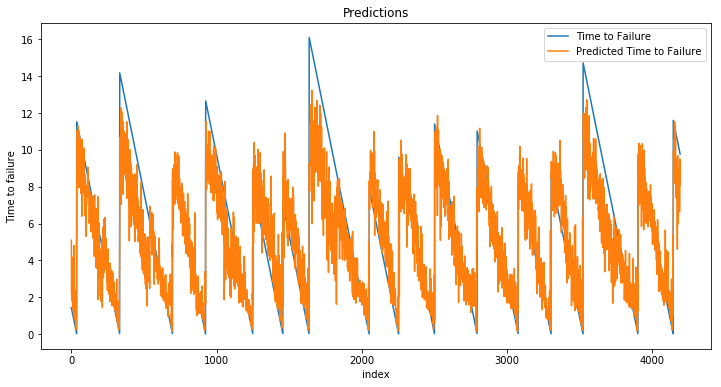

In [34]:
plot_op(predictions_check)

We can see that the model is able to detect most the earthquakes

## LGBM with feature set 1 and 2

In [6]:
predictions_check[0:10]

array([5.44475999, 5.01630807, 4.3423958 , 4.72229591, 4.7615773 ,
       4.38402993, 4.59371988, 5.86153722, 2.96471365, 3.55317467])

In [5]:
scaled_train_X2=pd.read_csv('scaled_train_X2.csv')
scaled_train_X=pd.read_csv('scaled_train_X.csv')
scaled_test_X=pd.read_csv('scaled_test_X.csv')
scaled_test_X2=pd.read_csv('scaled_test_X2.csv')
scaled_train_X=pd.concat([scaled_train_X,scaled_train_X2],axis=1)
scaled_test_X=pd.concat([scaled_test_X,scaled_test_X2],axis=1)

In [6]:
print(scaled_test_X2.shape)
scaled_train_X.shape

(2624, 67)


(24000, 932)

In [7]:
#with feature set 1 and 2
#1.351
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_f2_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    #scaled_train_X = scaled_train_X
    #scaled_test_X = scaled_test_X
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = scaled_train_X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(scaled_test_X, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)

        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(scaled_train_X.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('submission_lgb_2featureset.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dp.csv') 

In [8]:
lgb_f2_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04174	valid_1's l1: 2.06447
[2000]	training's l1: 1.85357	valid_1's l1: 1.90978
[3000]	training's l1: 1.77847	valid_1's l1: 1.85564
[4000]	training's l1: 1.71851	valid_1's l1: 1.8109
[5000]	training's l1: 1.67005	valid_1's l1: 1.77346
[6000]	training's l1: 1.62553	valid_1's l1: 1.74131
[7000]	training's l1: 1.58344	valid_1's l1: 1.71118
[8000]	training's l1: 1.54337	valid_1's l1: 1.68327
[9000]	training's l1: 1.50615	valid_1's l1: 1.65851
[10000]	training's l1: 1.47071	valid_1's l1: 1.63519
[11000]	training's l1: 1.4374	valid_1's l1: 1.61514
[12000]	training's l1: 1.40553	valid_1's l1: 1.59579
[13000]	training's l1: 1.37578	valid_1's l1: 1.57863
[14000]	training's l1: 1.34667	valid_1's l1: 1.56116
[15000]	training's l1: 1.31927	valid_1's l1: 1.54572
[16000]	training's l1: 1.29222	valid_1's l1: 1.53013
[17000]	training's l1: 1.26602	valid_1's l1: 1.51496
[18000]	training's l1: 1.

[70000]	training's l1: 0.541626	valid_1's l1: 1.23844
[71000]	training's l1: 0.534342	valid_1's l1: 1.23587
[72000]	training's l1: 0.527202	valid_1's l1: 1.23333
[73000]	training's l1: 0.520046	valid_1's l1: 1.23079
[74000]	training's l1: 0.513153	valid_1's l1: 1.22835
[75000]	training's l1: 0.506271	valid_1's l1: 1.22587
[76000]	training's l1: 0.49959	valid_1's l1: 1.22343
[77000]	training's l1: 0.493008	valid_1's l1: 1.2211
[78000]	training's l1: 0.486509	valid_1's l1: 1.21868
[79000]	training's l1: 0.48012	valid_1's l1: 1.21652
[80000]	training's l1: 0.473823	valid_1's l1: 1.21432
Did not meet early stopping. Best iteration is:
[80000]	training's l1: 0.473823	valid_1's l1: 1.21432
MAE: 1.214319
RMSE: 3.065115
working fold 2
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04528	valid_1's l1: 2.03237
[2000]	training's l1: 1.85908	valid_1's l1: 1.88365
[3000]	training's l1: 1.78371	valid_1's l1: 1.83037
[4000]	training's l1: 1.72373	valid_1

[56000]	training's l1: 0.661006	valid_1's l1: 1.28116
[57000]	training's l1: 0.651261	valid_1's l1: 1.27767
[58000]	training's l1: 0.641713	valid_1's l1: 1.27408
[59000]	training's l1: 0.632542	valid_1's l1: 1.27084
[60000]	training's l1: 0.623554	valid_1's l1: 1.26774
[61000]	training's l1: 0.614636	valid_1's l1: 1.26457
[62000]	training's l1: 0.605873	valid_1's l1: 1.26157
[63000]	training's l1: 0.597016	valid_1's l1: 1.25832
[64000]	training's l1: 0.588469	valid_1's l1: 1.2554
[65000]	training's l1: 0.580287	valid_1's l1: 1.25262
[66000]	training's l1: 0.572132	valid_1's l1: 1.24967
[67000]	training's l1: 0.564057	valid_1's l1: 1.24688
[68000]	training's l1: 0.556186	valid_1's l1: 1.24419
[69000]	training's l1: 0.548409	valid_1's l1: 1.24161
[70000]	training's l1: 0.540864	valid_1's l1: 1.23914
[71000]	training's l1: 0.533502	valid_1's l1: 1.23677
[72000]	training's l1: 0.526152	valid_1's l1: 1.23426
[73000]	training's l1: 0.519107	valid_1's l1: 1.23207
[74000]	training's l1: 0.5120

[42000]	training's l1: 0.81377	valid_1's l1: 1.35517
[43000]	training's l1: 0.801096	valid_1's l1: 1.35029
[44000]	training's l1: 0.78851	valid_1's l1: 1.3453
[45000]	training's l1: 0.776449	valid_1's l1: 1.3408
[46000]	training's l1: 0.764442	valid_1's l1: 1.33609
[47000]	training's l1: 0.75271	valid_1's l1: 1.33155
[48000]	training's l1: 0.741112	valid_1's l1: 1.32713
[49000]	training's l1: 0.729728	valid_1's l1: 1.32264
[50000]	training's l1: 0.718624	valid_1's l1: 1.3183
[51000]	training's l1: 0.707809	valid_1's l1: 1.31418
[52000]	training's l1: 0.697242	valid_1's l1: 1.31001
[53000]	training's l1: 0.687011	valid_1's l1: 1.30612
[54000]	training's l1: 0.676808	valid_1's l1: 1.30208
[55000]	training's l1: 0.666926	valid_1's l1: 1.29841
[56000]	training's l1: 0.657104	valid_1's l1: 1.2945
[57000]	training's l1: 0.647453	valid_1's l1: 1.2908
[58000]	training's l1: 0.63789	valid_1's l1: 1.28716
[59000]	training's l1: 0.628679	valid_1's l1: 1.28351
[60000]	training's l1: 0.619705	valid

[28000]	training's l1: 1.02975	valid_1's l1: 1.4054
[29000]	training's l1: 1.01189	valid_1's l1: 1.3976
[30000]	training's l1: 0.994592	valid_1's l1: 1.38962
[31000]	training's l1: 0.977956	valid_1's l1: 1.3822
[32000]	training's l1: 0.96129	valid_1's l1: 1.37476
[33000]	training's l1: 0.944915	valid_1's l1: 1.36743
[34000]	training's l1: 0.929174	valid_1's l1: 1.36094
[35000]	training's l1: 0.913958	valid_1's l1: 1.35491
[36000]	training's l1: 0.898947	valid_1's l1: 1.34842
[37000]	training's l1: 0.884567	valid_1's l1: 1.34222
[38000]	training's l1: 0.870371	valid_1's l1: 1.33636
[39000]	training's l1: 0.856678	valid_1's l1: 1.33098
[40000]	training's l1: 0.842974	valid_1's l1: 1.32503
[41000]	training's l1: 0.829744	valid_1's l1: 1.31952
[42000]	training's l1: 0.816886	valid_1's l1: 1.31435
[43000]	training's l1: 0.804321	valid_1's l1: 1.30967
[44000]	training's l1: 0.791705	valid_1's l1: 1.30445
[45000]	training's l1: 0.779561	valid_1's l1: 1.29972
[46000]	training's l1: 0.767631	va

In [22]:
print(scaled_train_X.isnull().any().any())
scaled_train_X=scaled_train_X.fillna(0)
scaled_test_X=scaled_test_X.fillna(0)
print(scaled_train_X.isnull().any().any())

False
False


## Feature Selection

In [32]:
import sklearn
#normalising, since sklearns selectkbest does not work with negative features
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_norm=scaler.fit_transform(scaled_train_X)
#converting to dataframe
X_train_norm=pd.DataFrame(X_train_norm,columns=scaled_train_X.columns)

              features         Score
826   q05_roll_std_100  17523.290389
825   q01_roll_std_100  17044.985850
804    q05_roll_std_10  16761.917094
917       num_peaks_10  16189.163749
411          abs_q05_4  16141.192817
412          abs_q01_4  16003.954512
803    q01_roll_std_10  15792.506711
482          abs_q05_5  15175.374271
848  q05_roll_std_1000  14811.628390
340          abs_q05_3  14803.987410
----------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------


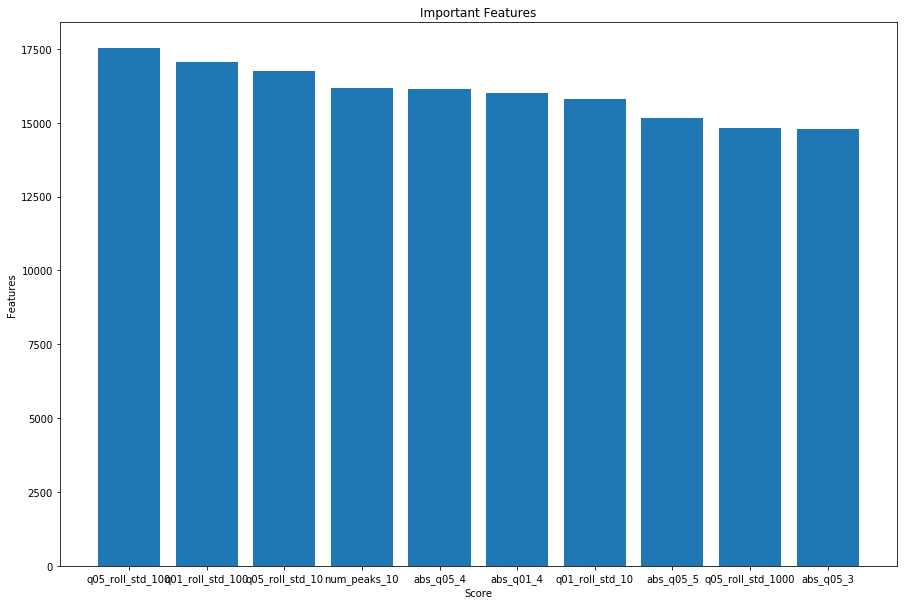

In [34]:
#using sklearns selectkbest
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
train_y = pd.read_csv('train_y.csv')
X = X_train_norm 
y = train_y
#  extracting top 10 features
bestfeatures = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=10)
fit = bestfeatures.fit(X,y)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
topfeatures = pd.concat([columns_df,scores_df],axis=1)
topfeatures.columns = ['features','Score']  

topfeatures=topfeatures.sort_values(by='Score',ascending=False)
print(topfeatures[0:10])

print('----------------------------------------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------------------------------------')
plt.bar(topfeatures.features[0:10],topfeatures.Score[0:10])
plt.ylabel('Features')
plt.title('Important Features')
plt.xlabel('Score')
plt.show()

In [55]:
#considering top 300 features
truncated_train=scaled_train_X[topfeatures[0:300]['features'].tolist()]

In [56]:
truncated_test=scaled_test_X[topfeatures[0:300]['features'].tolist()]

In [62]:
#with feature set 1 and 2
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_truncated_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    #scaled_train_X = scaled_train_X
    #scaled_test_X = scaled_test_X
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = truncated_train.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(truncated_train, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = truncated_train.iloc[trn_idx], truncated_train.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(truncated_test, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)

        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(truncated_train.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('submission_lgb_truncated.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dp.csv') 
    return model

In [63]:
clf7=lgb_truncated_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.05775	valid_1's l1: 2.08199
[2000]	training's l1: 1.87762	valid_1's l1: 1.93895
[3000]	training's l1: 1.8135	valid_1's l1: 1.89157
[4000]	training's l1: 1.76696	valid_1's l1: 1.85747
[5000]	training's l1: 1.72922	valid_1's l1: 1.8307
[6000]	training's l1: 1.69591	valid_1's l1: 1.80817
[7000]	training's l1: 1.66383	valid_1's l1: 1.78704
[8000]	training's l1: 1.63385	valid_1's l1: 1.76782
[9000]	training's l1: 1.60539	valid_1's l1: 1.74965
[10000]	training's l1: 1.57822	valid_1's l1: 1.73277
[11000]	training's l1: 1.55161	valid_1's l1: 1.71598
[12000]	training's l1: 1.52633	valid_1's l1: 1.70056
[13000]	training's l1: 1.50242	valid_1's l1: 1.68634
[14000]	training's l1: 1.47953	valid_1's l1: 1.67341
[15000]	training's l1: 1.45675	valid_1's l1: 1.66071
[16000]	training's l1: 1.43498	valid_1's l1: 1.64845
[17000]	training's l1: 1.41365	valid_1's l1: 1.63668
[18000]	training's l1: 1.

[70000]	training's l1: 0.734188	valid_1's l1: 1.38107
[71000]	training's l1: 0.726479	valid_1's l1: 1.37812
[72000]	training's l1: 0.718781	valid_1's l1: 1.37504
[73000]	training's l1: 0.711292	valid_1's l1: 1.37208
[74000]	training's l1: 0.704076	valid_1's l1: 1.36943
[75000]	training's l1: 0.696738	valid_1's l1: 1.36665
[76000]	training's l1: 0.689424	valid_1's l1: 1.3637
[77000]	training's l1: 0.682394	valid_1's l1: 1.3609
[78000]	training's l1: 0.675382	valid_1's l1: 1.35814
[79000]	training's l1: 0.668418	valid_1's l1: 1.3554
[80000]	training's l1: 0.661623	valid_1's l1: 1.35268
Did not meet early stopping. Best iteration is:
[80000]	training's l1: 0.661623	valid_1's l1: 1.35268
MAE: 1.352682
RMSE: 3.641151
working fold 2
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.06166	valid_1's l1: 2.05121
[2000]	training's l1: 1.88595	valid_1's l1: 1.91016
[3000]	training's l1: 1.82232	valid_1's l1: 1.86581
[4000]	training's l1: 1.77403	valid_1

[57000]	training's l1: 0.847342	valid_1's l1: 1.40442
[58000]	training's l1: 0.837881	valid_1's l1: 1.40048
[59000]	training's l1: 0.828629	valid_1's l1: 1.39678
[60000]	training's l1: 0.819547	valid_1's l1: 1.39305
[61000]	training's l1: 0.81089	valid_1's l1: 1.38962
[62000]	training's l1: 0.802129	valid_1's l1: 1.38609
[63000]	training's l1: 0.793508	valid_1's l1: 1.38254
[64000]	training's l1: 0.785069	valid_1's l1: 1.37912
[65000]	training's l1: 0.776744	valid_1's l1: 1.37583
[66000]	training's l1: 0.768621	valid_1's l1: 1.37255
[67000]	training's l1: 0.760615	valid_1's l1: 1.36944
[68000]	training's l1: 0.752657	valid_1's l1: 1.36624
[69000]	training's l1: 0.744809	valid_1's l1: 1.36316
[70000]	training's l1: 0.737134	valid_1's l1: 1.36023
[71000]	training's l1: 0.729469	valid_1's l1: 1.35715
[72000]	training's l1: 0.721947	valid_1's l1: 1.35415
[73000]	training's l1: 0.714579	valid_1's l1: 1.35129
[74000]	training's l1: 0.707323	valid_1's l1: 1.34851
[75000]	training's l1: 0.7000

[44000]	training's l1: 0.980834	valid_1's l1: 1.47239
[45000]	training's l1: 0.969161	valid_1's l1: 1.46755
[46000]	training's l1: 0.957939	valid_1's l1: 1.4628
[47000]	training's l1: 0.946793	valid_1's l1: 1.45794
[48000]	training's l1: 0.935887	valid_1's l1: 1.45341
[49000]	training's l1: 0.924835	valid_1's l1: 1.44847
[50000]	training's l1: 0.914095	valid_1's l1: 1.4438
[51000]	training's l1: 0.903699	valid_1's l1: 1.43936
[52000]	training's l1: 0.893359	valid_1's l1: 1.43498
[53000]	training's l1: 0.883289	valid_1's l1: 1.43073
[54000]	training's l1: 0.873404	valid_1's l1: 1.42664
[55000]	training's l1: 0.863488	valid_1's l1: 1.42228
[56000]	training's l1: 0.853801	valid_1's l1: 1.41792
[57000]	training's l1: 0.844401	valid_1's l1: 1.41403
[58000]	training's l1: 0.835164	valid_1's l1: 1.41023
[59000]	training's l1: 0.82572	valid_1's l1: 1.40632
[60000]	training's l1: 0.816687	valid_1's l1: 1.40244
[61000]	training's l1: 0.807614	valid_1's l1: 1.39852
[62000]	training's l1: 0.798913

[30000]	training's l1: 1.17017	valid_1's l1: 1.53899
[31000]	training's l1: 1.15511	valid_1's l1: 1.53229
[32000]	training's l1: 1.13996	valid_1's l1: 1.52547
[33000]	training's l1: 1.12497	valid_1's l1: 1.51876
[34000]	training's l1: 1.11006	valid_1's l1: 1.51188
[35000]	training's l1: 1.09552	valid_1's l1: 1.50491
[36000]	training's l1: 1.08163	valid_1's l1: 1.49845
[37000]	training's l1: 1.06774	valid_1's l1: 1.49204
[38000]	training's l1: 1.05449	valid_1's l1: 1.48625
[39000]	training's l1: 1.04139	valid_1's l1: 1.4806
[40000]	training's l1: 1.02831	valid_1's l1: 1.47498
[41000]	training's l1: 1.01558	valid_1's l1: 1.46973
[42000]	training's l1: 1.00301	valid_1's l1: 1.46444
[43000]	training's l1: 0.990731	valid_1's l1: 1.45917
[44000]	training's l1: 0.978695	valid_1's l1: 1.45396
[45000]	training's l1: 0.967024	valid_1's l1: 1.44896
[46000]	training's l1: 0.955334	valid_1's l1: 1.44391
[47000]	training's l1: 0.943973	valid_1's l1: 1.4389
[48000]	training's l1: 0.932841	valid_1's l

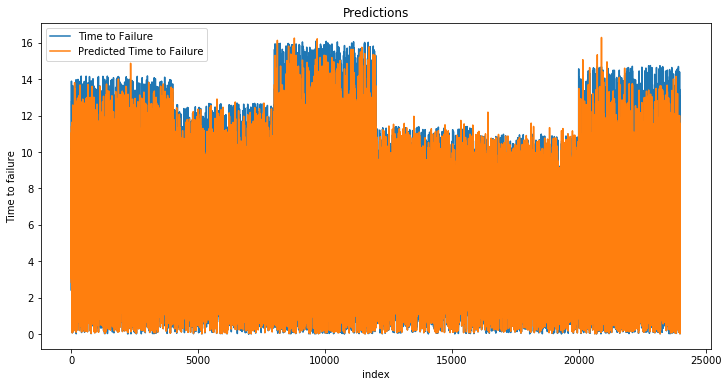

In [69]:
y_predicted=clf7.predict(truncated_train,num_iteration=clf7.best_iteration_)
plot_op(y_predicted)

# XGBOOST

In [3]:

def train_model_xgb( params ):
    X=pd.read_csv('scaled_train_X.csv')
    X_testset=pd.read_csv('scaled_test_X.csv')
    scaled_check_X=pd.read_csv('scaled_check_X.csv')
    
    scaled_train_X=pd.read_csv('scaled_train_X.csv')
    y=pd.read_csv('train_y.csv')
    
    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    x_value = np.zeros(len(X))
    prediction = np.zeros(len(X_testset))
    prediction_train = np.zeros(len(scaled_train_X))
    prediction_check = np.zeros(len(scaled_check_X))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (trainset_index, valid_set_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train_per_fold, X_valid_per_fold = X.iloc[trainset_index], X.iloc[valid_set_index]
        y_train_per_fold, y_valid_per_fold = y.iloc[trainset_index], y.iloc[valid_set_index]

        train_data = xgb.DMatrix(data=X_train_per_fold, label=y_train_per_fold, feature_names=X.columns)
        valid_data = xgb.DMatrix(data=X_valid_per_fold, label=y_valid_per_fold, feature_names=X.columns)

        watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
        model = xgb.train(dtrain=train_data, num_boost_round=800, evals=watchlist, early_stopping_rounds=200, verbose_eval=800, params=params)
        y_pred_valid = model.predict(xgb.DMatrix(X_valid_per_fold, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        y_pred = model.predict(xgb.DMatrix(X_testset, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        y_pred_check = model.predict(xgb.DMatrix(scaled_check_X, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        y_pred_train = model.predict(xgb.DMatrix(scaled_train_X, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        x_value[valid_set_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid_per_fold, y_pred_valid))

        prediction +=y_pred
        prediction_train+=y_pred_train
        prediction_check+=y_pred_check
        
        

    prediction /= n_fold
    prediction_train/= n_fold
    prediction_check/= n_fold
    
    print('CV mean score: {0:.6f}.'.format(mean_absolute_error(y, x_value)))
    return model,x_value, prediction,prediction_train,prediction_check

In [4]:
xgb_params = {'eta': 0.01,
              'max_depth': 6,             
              'colsample_bytree': 0.9,
              'lambda': 0.1,
              'alpha' : 0.1,
              'objective': 'reg:gamma',
              'eval_metric': 'mae',
              'silent': True, 'nthread':24}
model, x_value_xgb, prediction_xgb,prediction_train_xgb,prediction_check_xgb = train_model_xgb(params=xgb_params)

Fold 0 started at Sun May 26 04:16:11 2019
[0]	train-mae:5.29924	valid_data-mae:5.32894
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[799]	train-mae:1.51174	valid_data-mae:1.67802
Fold 1 started at Sun May 26 04:18:04 2019
[0]	train-mae:5.29436	valid_data-mae:5.36295
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[799]	train-mae:1.49884	valid_data-mae:1.72009
Fold 2 started at Sun May 26 04:19:55 2019
[0]	train-mae:5.31318	valid_data-mae:5.23115
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[799]	train-mae:1.50613	valid_data-mae:1.67086
Fold 3 started at Sun May 26 04:21:47 2019
[0]	train-mae:5.30434	valid_data-mae:5.29324
Multiple eval metrics have been passed: 'vali

In [6]:
pd.DataFrame(prediction_train_xgb).to_csv("prediction_train_xgb_800.csv", header=None, index=None)
pd.DataFrame(prediction_check_xgb).to_csv("prediction_check_xgb_800.csv", header=None, index=None)   

In [5]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_xgb
submission.to_csv('xgboost800unsavedmodel.csv')

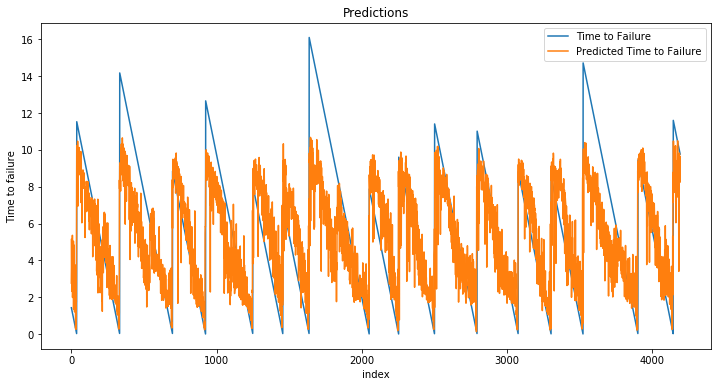

In [12]:
plot_op(prediction_check_xgb)

we can see that the predictions are generalising well and not overfitting .

## Stacking

In [84]:
train_pred_lgb=pd.read_csv('predictions_train_lgb.csv',header=None)
train_pred_xgb=pd.read_csv('prediction_train_xgb_800.csv',header=None)

test_pred_lgb=pd.read_csv('submission_lgb_with_gamma.csv')
test_pred_xgb=pd.read_csv('xgboost800unsavedmodel.csv')


In [85]:
train_pred_lgb=train_pred_lgb.drop(train_pred_lgb.columns[0], axis=1)

In [87]:
test_pred_xgb=test_pred_xgb['time_to_failure']

In [89]:
from sklearn.linear_model import LinearRegression
#train_stack = np.vstack([train_pred_lgb, train_pred_xgb]).transpose()
#test_stack = np.vstack([test_pred_lgb,test_pred_xgb]).transpose()
df = pd.concat([train_pred_lgb, train_pred_xgb], axis=1)
df_test = pd.concat([test_pred_lgb, test_pred_xgb], axis=1)
train_y = pd.read_csv('train_y.csv')

model = LinearRegression(fit_intercept=True)
model.fit(df,train_y)
stacked_predictions=model.predict(df_test)

In [90]:
stacked_predictions[0:10]

array([[3.57879183],
       [4.89777915],
       [5.31633825],
       [8.67293754],
       [6.13879032],
       [1.86658712],
       [8.55401978],
       [4.58090179],
       [4.18928864],
       [2.20161818]])

In [92]:
#1.379
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = stacked_predictions
submission.to_csv('stacked_predictionslr.csv')

## Conclusion

Objective:To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

1. We are given a dataset with  629145480 rows and 2 columns: acoustic_data, time_to_failure, where time_to_failure is the time remaining for next earthquake.
<br>
2. We visualize the train and test data to get the pattern and observer that there is a spike in siesmic data before earthquake occurs and there are a total of 16 earthquakes in train data.
<br>
3. We divide the data into 6 slice and take 4000 random samples from each slice and get 24000 training data rows. We use multiprocessing to reduce the time taken to run.
<br>
4. We then featurize the data using simple statistical features like mean,std,moving averages etc and also signal processing features like fft, peaks, hjorth parameters.
<br>
5. I tried hyperparameter tuning with gridsearchcv and the performance reduced,we can also see by results that CV is reliable, hence i used the default values. 
<br>
6. We Apply various machine learning models, we use 8 fold cv \and compare the cross validation result and plot the corresponding feature importances.
<br>
7. Since not all features contribute to the model, we use feature selection to get the top features.
<br>
8. We use sklearns selectkbest to find the top 300 features and then apply models on it and compare them, the score went down slightly.
<br>
9. We try simple stacking of the models with linear regression as model and the score doesnt improve.

In [13]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Feature Selection','Feature set','Algorithm','CV MAE','TEST MAE']
x.add_row([" - ",'Feature set1',"XGB",1.69,1.314])
x.add_row([" - ",'Feature set1',"LGBM",1.218,1.340])
x.add_row([" selectkbest ",'Feature set1+2',"LGBM", 1.325,1.455])
x.add_row(["-",'Feature set1+2',"LGBM",1.199,3.51])

print(x)

+-------------------+----------------+-----------+--------+----------+
| Feature Selection |  Feature set   | Algorithm | CV MAE | TEST MAE |
+-------------------+----------------+-----------+--------+----------+
|         -         |  Feature set1  |    XGB    |  1.69  |  1.314   |
|         -         |  Feature set1  |    LGBM   | 1.218  |   1.34   |
|    selectkbest    | Feature set1+2 |    LGBM   | 1.325  |  1.455   |
|         -         | Feature set1+2 |    LGBM   | 1.199  |   3.51   |
+-------------------+----------------+-----------+--------+----------+


We can see that cv might not be reliable

XGB gives the highest score of 1.314 which is currently at the 27th position at the kaggle public leaderboard.